In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from datetime import datetime
from mpl_toolkits.basemap import Basemap

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
TID=test['TID']
pd.set_option('display.width', 150)

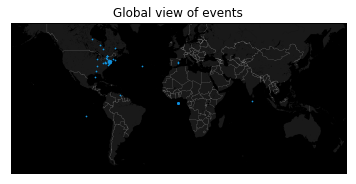

In [7]:
# Mapping Location on world Map
m1 = Basemap(projection='merc',
             llcrnrlat=-60,
             urcrnrlat=65,
             llcrnrlon=-180,
             urcrnrlon=180,
             lat_ts=0,
             resolution='f')

m1.fillcontinents(color='#191919',lake_color='#000000') # dark grey land, black lakes
m1.drawmapboundary(fill_color='#000000')                # black background
m1.drawcountries(linewidth=0.1, color="w")              # thin white line for country borders

# Plot the data
mxy = m1(train['pickup_longitude'].tolist(), train['pickup_latitude'].tolist())
m1.scatter(mxy[0], mxy[1], s=3, c="#1292db", lw=0, alpha=1, zorder=5)

plt.title("Global view of events")
plt.show()

In [3]:
train['new_user'].fillna('NO', inplace=True)
test['new_user'].fillna('NO', inplace=True)

train['tip_amount'].fillna(train['tip_amount'].median(), inplace=True)
test['tip_amount'].fillna(test['tip_amount'].median(), inplace=True)

train['pickup_longitude'].fillna(train['pickup_longitude'].mode()[0], inplace=True)
test['pickup_longitude'].fillna(test['pickup_longitude'].mode()[0], inplace=True)

train['pickup_latitude'].fillna(train['pickup_latitude'].mode()[0], inplace=True)
test['pickup_latitude'].fillna(test['pickup_latitude'].mode()[0], inplace=True)

train['dropoff_longitude'].fillna(train['dropoff_longitude'].mode()[0], inplace=True)
test['dropoff_longitude'].fillna(test['dropoff_longitude'].mode()[0], inplace=True)

train['dropoff_latitude'].fillna(train['dropoff_latitude'].mode()[0], inplace=True)
test['dropoff_latitude'].fillna(test['dropoff_latitude'].mode()[0], inplace=True)

In [4]:
train['surcharge'].fillna(train['surcharge'].median(), inplace=True)
test['surcharge'].fillna(test['surcharge'].median(), inplace=True)

In [5]:
drop_col = ['TID', 'store_and_fwd_flag']

In [6]:
cate_vars = ['vendor_id', 'payment_type']
one_hot_train = pd.get_dummies(train[cate_vars])
one_hot_test = pd.get_dummies(test[cate_vars])
     

In [7]:
cols = list(test.columns)

train_label = train['fare_amount']

train = train[list(set(cols) - set(cate_vars))]
test = test[list(set(cols) - set(cate_vars))]


In [8]:
train = pd.concat([train, one_hot_train], axis=1)
test = pd.concat([test, one_hot_test], axis=1)

In [9]:
col1 = set(train.columns)
col2 = set(test.columns)
temp = list(col1.intersection(col2))
train = train[temp]
test = test[temp]

In [10]:
# Calculating time
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'])

test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])
test['dropoff_datetime'] = pd.to_datetime(test['dropoff_datetime'])



In [11]:
train['time_elapsed'] = (train['dropoff_datetime'] - train['pickup_datetime']).astype('timedelta64[m]')
test['time_elapsed'] = (test['dropoff_datetime'] - test['pickup_datetime']).astype('timedelta64[m]')

In [12]:
train['year'] = train['pickup_datetime'].dt.year
test['year'] = test['pickup_datetime'].dt.year

train['dayofweek'] = train['pickup_datetime'].dt.dayofweek
test['dayofweek'] = test['pickup_datetime'].dt.dayofweek

train['hour'] = train['pickup_datetime'].dt.hour
test['hour'] = test['pickup_datetime'].dt.hour


In [13]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [14]:
train['distance'] = haversine_np(train['pickup_longitude'], train['pickup_latitude'], train['dropoff_longitude'], train['dropoff_latitude'])
test['distance'] = haversine_np(test['pickup_longitude'], test['pickup_latitude'], test['dropoff_longitude'], test['dropoff_latitude'])

In [15]:
train['ne_user'] = train['new_user']=='YES'
test['ne_user'] = test['new_user']=='YES'

In [16]:
# drop_cols = ['year','TID','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','pickup_datetime','dropoff_datetime','store_and_fwd_flag', 'new_user']                   
drop_cols = ['TID','pickup_datetime','dropoff_datetime','store_and_fwd_flag', 'new_user']                   
train = train.drop(labels=drop_cols, axis=1)
test = test.drop(labels=drop_cols, axis=1)

In [17]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
model = RandomForestRegressor(n_estimators=80, n_jobs=-1)
model.fit(train, train_label)


In [ ]:
prediction = model.predict(test)

In [ ]:
subm_file = pd.read_csv('sample_submission.csv')

In [ ]:
subm_file['TID'] = TID
subm_file['fare_amount'] = prediction

In [ ]:
subm_file.to_csv('final_submission.csv', index=False)